In [1]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import ast
import re

sys.path.append(r"C:\Users\janbe\Documents\GitHub Repos\pulse")
from src.eval.llm_analyzer import LLMAnalyzer, ModelAnalyzer
from src.eval.pulse_score import PULSEScoreCalculator

# Configuration and setup
import warnings

warnings.filterwarnings("ignore")

In [2]:
# Set up directories
base_dir = r"C:\Users\janbe\Documents\GitHub Repos\pulse"
results_dir = os.path.join(base_dir, "output_to_keep", "results_benchmark")

In [3]:
model_list = os.listdir(results_dir)
model_list

['20250603_160304_CNN',
 '20250603_192812_GRU',
 '20250604_094650_LSTM',
 '20250604_145501_XGBoost',
 '20250604_151243_LightGBM',
 '20250604_151406_RandomForest',
 '20250617_131406_InceptionTime',
 'llms']

Conventional Models

In [4]:
result_dict = {}
for model in model_list:
    if model == "llms":
        continue
    print(f"Processing {model}...")
    cat_files = ModelAnalyzer.categorize_files(
        [os.path.join(results_dir, model)],
        verbose=False,
    )
    df_mdata = LLMAnalyzer.load_metadata(cat_files["metadata_files"])
    df_mdata = ModelAnalyzer.expand_full_dataset(df_mdata)
    # Strip "Model" from model_name and save as model_id
    df_mdata['model_id'] = df_mdata['model_name'].str.replace("Model", "", regex=False).str.strip()
    model_id = df_mdata['model_id'].unique()[0]
    result_dict[model_id] = {"score": None, "mdata": df_mdata}


# Calculate PULSE scores for each model
psc = PULSEScoreCalculator()
for model, data in result_dict.items():
    print(f"Calculating PULSE score for {model}...")
    df_mdata = data["mdata"]
    if df_mdata.empty:
        continue
    score = psc.calculate_pulse_score_from_dataframe(
        df=df_mdata,
        target_col="label_value",
        prob_col="probability",
        pred_col="binary_prediction",
        task_col="task",
        dataset_col="dataset",
    )
    result_dict[model]["score"] = score

Processing 20250603_160304_CNN...
Model Name: CNNModel, Task: aki, Dataset: eicu, Timestamp: 20250605_113136
Model Name: CNNModel, Task: aki, Dataset: hirid, Timestamp: 20250605_113136


Model Name: CNNModel, Task: aki, Dataset: miiv, Timestamp: 20250605_113136
Model Name: CNNModel, Task: mortality, Dataset: eicu, Timestamp: 20250603_160304
Model Name: CNNModel, Task: mortality, Dataset: hirid, Timestamp: 20250603_160304
Model Name: CNNModel, Task: mortality, Dataset: miiv, Timestamp: 20250603_160304
Model Name: CNNModel, Task: sepsis, Dataset: eicu, Timestamp: 20250605_113136
Model Name: CNNModel, Task: sepsis, Dataset: hirid, Timestamp: 20250605_113136
Model Name: CNNModel, Task: sepsis, Dataset: miiv, Timestamp: 20250605_113136
Processing 20250603_192812_GRU...
Model Name: GRUModel, Task: aki, Dataset: eicu, Timestamp: 20250603_192812
Model Name: GRUModel, Task: aki, Dataset: hirid, Timestamp: 20250603_192812
Model Name: GRUModel, Task: aki, Dataset: miiv, Timestamp: 20250603_192812
Model Name: GRUModel, Task: mortality, Dataset: eicu, Timestamp: 20250603_192812
Model Name: GRUModel, Task: mortality, Dataset: hirid, Timestamp: 20250603_192812
Model Name: GRUModel, T

In [5]:
result_dict["CNN"]['score']['overall']

{'pulse_score': np.float64(59.3502164303003),
 'task_scores': {'aki': np.float64(67.55635763548413),
  'mortality': np.float64(68.23671443473454),
  'sepsis': np.float64(42.25757722068221)},
 'task_dataset_scores': {'aki_eicu': np.float64(70.80411327912887),
  'aki_hirid': np.float64(63.2571298151861),
  'aki_miiv': np.float64(68.60782981213747),
  'mortality_eicu': np.float64(66.28240037139268),
  'mortality_hirid': np.float64(72.68594892638772),
  'mortality_miiv': np.float64(65.74179400642319),
  'sepsis_eicu': np.float64(35.567144181063135),
  'sepsis_hirid': np.float64(51.890051409269645),
  'sepsis_miiv': np.float64(39.315536071713844)},
 'weights_used': {'sepsis': 0.33, 'mortality': 0.33, 'aki': 0.33}}

LLMs

In [6]:
llm_model_list = os.listdir(os.path.join(results_dir, "llms"))

In [7]:
for llm_model in llm_model_list:
    print("===================================================")
    print(f"Processing LLM model: {llm_model}...")
    result_dict[llm_model] = {}
    prompt_approaches = os.listdir(os.path.join(results_dir, "llms", llm_model))
    for prompt_approach in prompt_approaches:
        print(f"Processing {prompt_approach}...")
        cat_files = LLMAnalyzer.categorize_files(
            [os.path.join(results_dir, "llms", llm_model, prompt_approach)],
            verbose=False,
        )
        df_mdata = LLMAnalyzer.load_metadata(cat_files["metadata_files"])
        if "Step Name" in df_mdata.columns:
            df_mdata = df_mdata[df_mdata["Step Name"] == "final_prediction"]
        ps = PULSEScoreCalculator()
        pulse_score = ps.calculate_pulse_score_from_raw_data(
            df=df_mdata,
            show_plots=False,
            show_insights=True,
            show_detailed_report=False,

        )
        result_dict[llm_model][prompt_approach] = {
                "score": pulse_score,
                "mdata": df_mdata,
        }
        print("--------------------------------------------")

Processing LLM model: deepseekr1llama8b...
Processing liu_2023_few_shot_preprocessor...


Model Name: DeepseekR1Llama8b, Task: aki, Dataset: eicu, Timestamp: 20250626_123125
Model Name: DeepseekR1Llama8b, Task: aki, Dataset: hirid, Timestamp: 20250626_123125
Model Name: DeepseekR1Llama8b, Task: aki, Dataset: miiv, Timestamp: 20250626_123125
Model Name: DeepseekR1Llama8b, Task: mortality, Dataset: eicu, Timestamp: 20250626_123125
Model Name: DeepseekR1Llama8b, Task: mortality, Dataset: hirid, Timestamp: 20250626_123125
Model Name: DeepseekR1Llama8b, Task: mortality, Dataset: miiv, Timestamp: 20250626_123125
Model Name: DeepseekR1Llama8b, Task: sepsis, Dataset: eicu, Timestamp: 20250626_123125
Model Name: DeepseekR1Llama8b, Task: sepsis, Dataset: hirid, Timestamp: 20250626_123125
Model Name: DeepseekR1Llama8b, Task: sepsis, Dataset: miiv, Timestamp: 20250626_123125
Preparing data for DeepseekR1Llama8b PULSE score calculation...
Calculating PULSE scores...
✅ PULSE scores calculated successfully for DeepseekR1Llama8b!
🔍 KEY INSIGHTS - PULSE SCORE ANALYSIS
🎯 FINAL PULSE SCORE: 4

In [8]:
PLOT_VARIABLES = {
    'deepseekr1llama8b': 'DeepSeek-R1 (Llama-8B)',
    'gemini2p5flash': 'Gemini 2.5 Flash',
    'gemma3': 'Gemma 3 4B',
    'gpt4o': 'GPT-4o',
    'llama3p18b': 'Llama 3 8B',
    'medgemma': 'MedGemma 4B',
    'mistral7b': 'Mistral 7B'
    ,
    'collaborative_reasoning_agent_preprocessor': 'Collaborative Reasoning',
    'liu_2023_few_shot_preprocessor': 'Few-Shot',
    'sarvari_2024_aggregation_preprocessor': 'Aggregation',
    'zhu_2024a_cot_preprocessor': 'CoT',
    'zhu_2024b_one_shot_preprocessor': 'One-Shot',
    'zhu_2024b_zero_shot_preprocessor': 'Zero-Shot',
    'zhu_2024c_categorization_summary_agent_preprocessor': 'Categorization Summary Agent'
}


In [9]:
import matplotlib

def plot_pulse_scores(result_dict, score_key_path=['score', 'overall', 'pulse_score'], 
                     title='Overall PULSE Scores by Model', ylabel='PULSE Score',
                     figsize=(14, 10), show_plot=True):
    """
    Create a bar plot of PULSE scores for different models and approaches.
    
    Parameters:
    -----------
    result_dict : dict
        Dictionary containing model results with scores and metadata
    score_key_path : list
        Path to the score value in the nested dictionary structure
    title : str
        Title for the plot
    ylabel : str
        Label for the y-axis
    figsize : tuple
        Figure size (width, height)
    show_plot : bool
        Whether to display the plot
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The created figure object
    """
    # Extract model names and overall scores
    models = []
    scores = []

    # Assign a unique color to each model_name (before approach is appended)
    unique_model_names = []
    for model_name, model_data in result_dict.items():
        # Navigate through the score_key_path to check if score exists
        score_data = model_data
        score_exists = True
        for key in score_key_path:
            if isinstance(score_data, dict) and key in score_data and score_data[key] is not None:
                score_data = score_data[key]
            else:
                score_exists = False
                break

        if score_exists:
            unique_model_names.append(model_name)
        elif isinstance(model_data, dict):
            unique_model_names.append(model_name)

    unique_model_names = list(dict.fromkeys(unique_model_names))  # preserve order, remove duplicates

    # Generate a color map for each model_name
    color_map = {}
    cmap = matplotlib.colormaps['tab20c']
    colors = cmap(np.linspace(0, 1, len(unique_model_names)))
    color_map = {name: colors[i] for i, name in enumerate(unique_model_names)}

    bar_colors = []
    for model_name, model_data in result_dict.items():
        # Navigate through the score_key_path to check if score exists
        score_data = model_data
        score_exists = True
        for key in score_key_path:
            if isinstance(score_data, dict) and key in score_data and score_data[key] is not None:
                score_data = score_data[key]
            else:
                score_exists = False
                break

        if score_exists:
            bar_colors.append(color_map[model_name])
        elif isinstance(model_data, dict):
            for approach, approach_data in model_data.items():
                # Navigate through the score_key_path for approach data
                approach_score_data = approach_data
                approach_score_exists = True
                for key in score_key_path:
                    if isinstance(approach_score_data, dict) and key in approach_score_data and approach_score_data[key] is not None:
                        approach_score_data = approach_score_data[key]
                    else:
                        approach_score_exists = False
                        break

                if approach_score_exists:
                    bar_colors.append(color_map[model_name])

    for model_name, model_data in result_dict.items():
        # Navigate through the score_key_path to check if score exists
        score_data = model_data
        score_exists = True
        for key in score_key_path:
            if isinstance(score_data, dict) and key in score_data and score_data[key] is not None:
                score_data = score_data[key]
            else:
                score_exists = False
                break

        if score_exists:
            overall_score = score_data
            models.append(PLOT_VARIABLES.get(model_name, model_name))
            scores.append(overall_score)
        elif isinstance(model_data, dict):
            for approach, approach_data in model_data.items():
                # Navigate through the score_key_path for approach data
                approach_score_data = approach_data
                approach_score_exists = True
                for key in score_key_path:
                    if isinstance(approach_score_data, dict) and key in approach_score_data and approach_score_data[key] is not None:
                        approach_score_data = approach_score_data[key]
                    else:
                        approach_score_exists = False
                        break

                if approach_score_exists:
                    overall_score = approach_score_data
                    models.append(
                        f"{PLOT_VARIABLES.get(model_name, model_name)} ({PLOT_VARIABLES.get(approach, approach)})"
                    )
                    scores.append(overall_score)

    # Create a plot
    fig = plt.figure(figsize=figsize)
    plt.style.use('seaborn-v0_8-whitegrid')
    bars = plt.bar(models, scores, color=bar_colors, alpha=0.8, edgecolor='white', linewidth=1.5)

    # Add a subtle grid
    plt.grid(axis='x', alpha=0.3, linestyle='--', linewidth=0.5)

    # Add value labels on top of bars with better formatting
    for bar, score in zip(bars, scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.8, 
                 f'{score:.1f}', ha='center', va='bottom', fontsize=10)

    plt.title(title, fontsize=20, fontweight="bold", pad=20)
    plt.xlabel("Model", fontsize=14, fontweight="bold")
    plt.ylabel(ylabel, fontsize=14, fontweight="bold")
    plt.xticks(rotation=45, ha="right", fontsize=11)
    plt.yticks(fontsize=11)
    plt.tight_layout()

    return fig

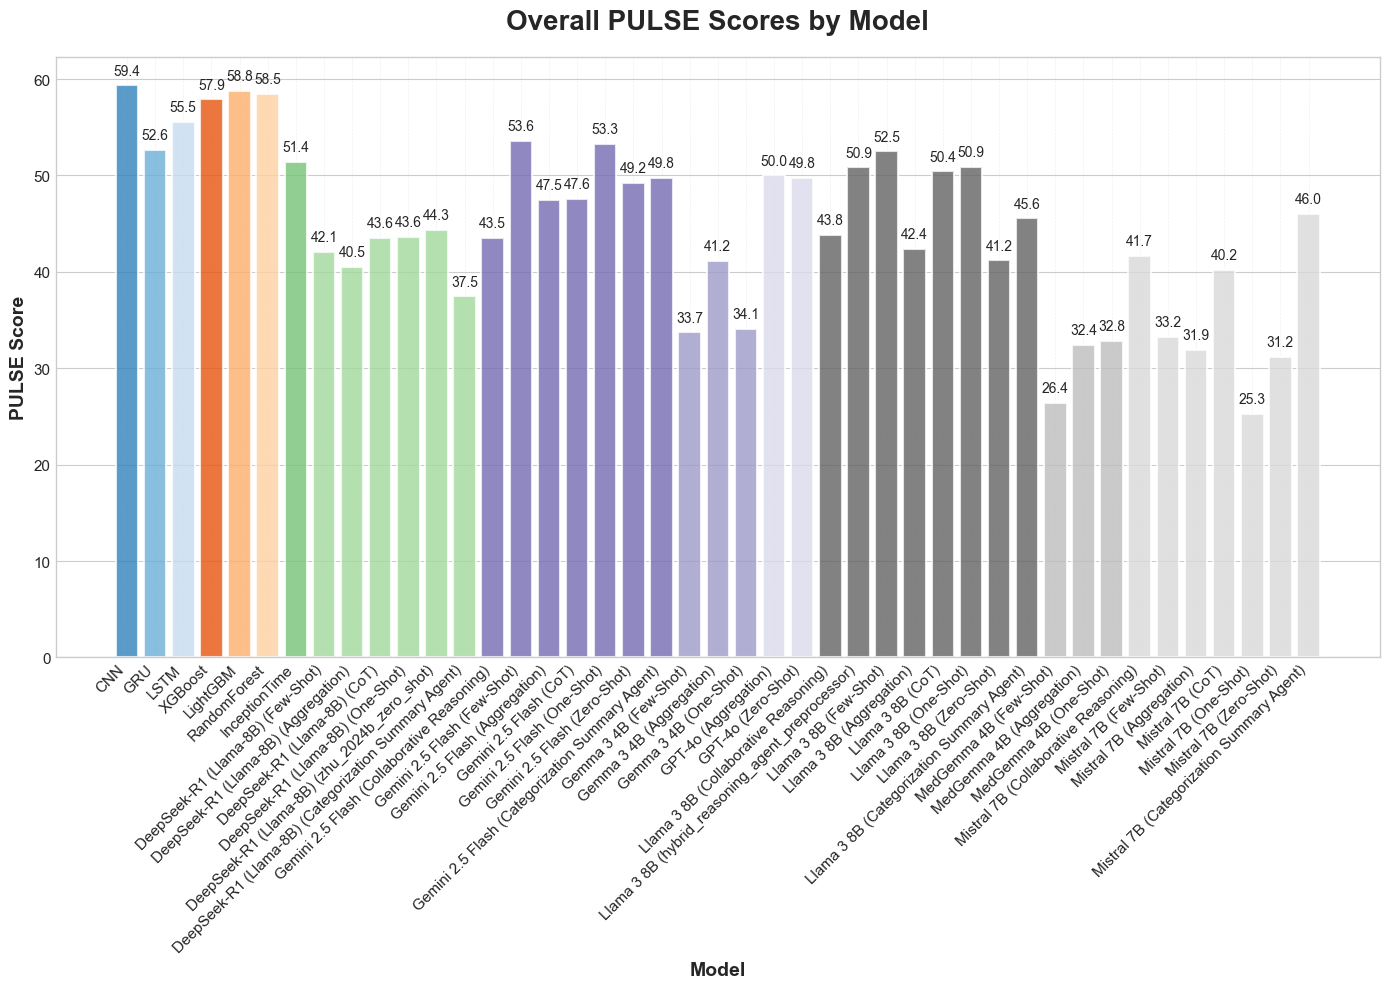

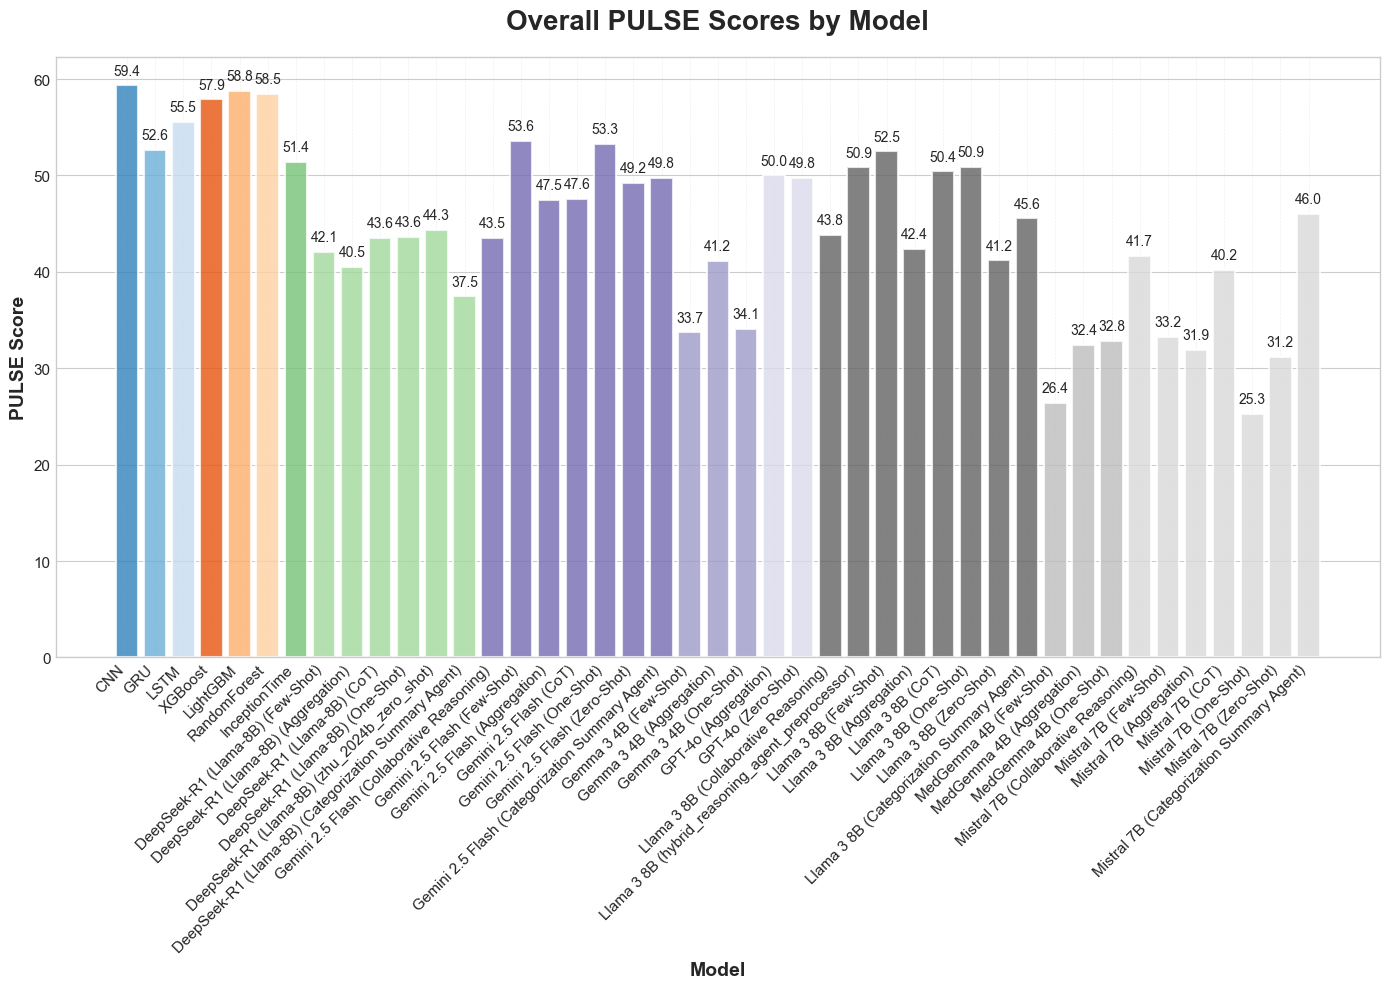

In [10]:
plot_pulse_scores(result_dict)

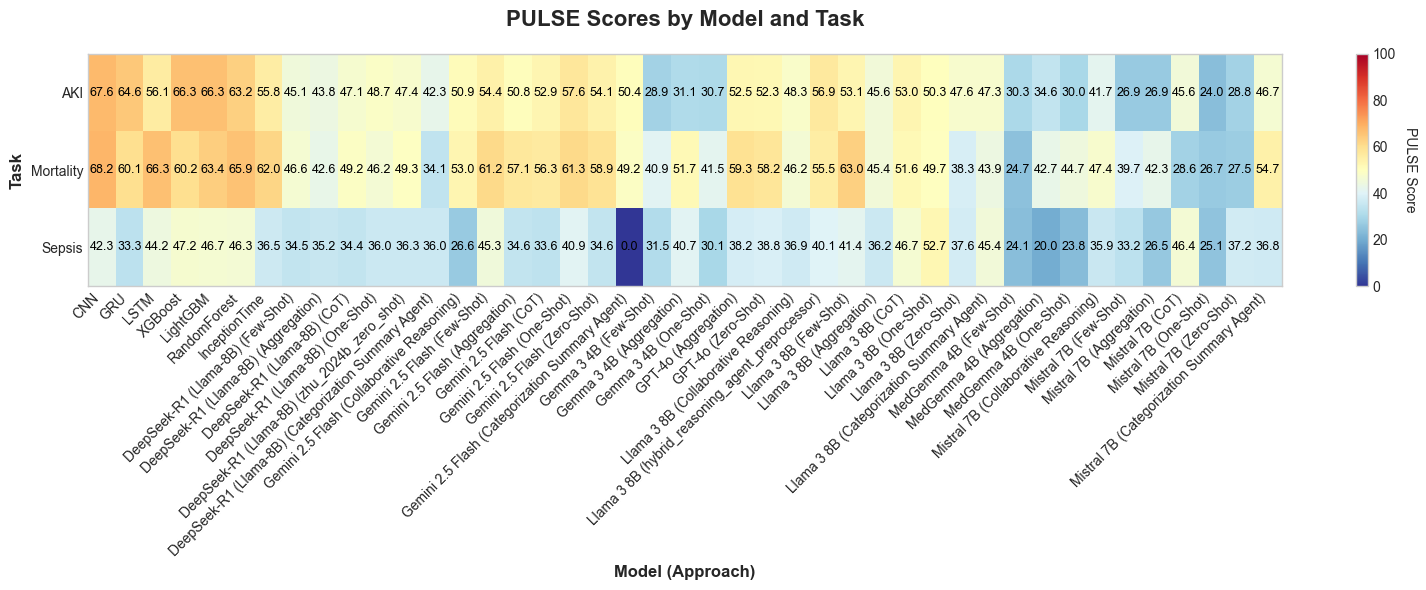

In [11]:
# Create data for confusion matrix-style heatmap
tasks = ['AKI', 'Mortality', 'Sepsis']
model_approach_combinations = []
heatmap_data = []

# Collect all model-approach combinations and their task scores
for model_name, model_data in result_dict.items():
    if 'score' in model_data and model_data['score'] is not None:
        # Traditional models
        model_label = PLOT_VARIABLES.get(model_name, model_name)
        model_approach_combinations.append(model_label)
        
        task_scores = []
        for task in ['aki', 'mortality', 'sepsis']:
            score = model_data['score']['overall']['task_scores'].get(task, 0)
            task_scores.append(score)
        heatmap_data.append(task_scores)
        
    elif isinstance(model_data, dict):
        # LLM models with approaches
        for approach, approach_data in model_data.items():
            if 'score' in approach_data and approach_data['score'] is not None and 'overall' in approach_data['score']:
                model_label = f"{PLOT_VARIABLES.get(model_name, model_name)} ({PLOT_VARIABLES.get(approach, approach)})"
                model_approach_combinations.append(model_label)
                
                task_scores = []
                for task in ['aki', 'mortality', 'sepsis']:
                    score = approach_data['score']['overall']['task_scores'].get(task, 0)
                    task_scores.append(score)
                heatmap_data.append(task_scores)

# Convert to numpy array for heatmap
heatmap_data = np.array(heatmap_data).T  # Transpose so tasks are on y-axis

# Create heatmap
plt.figure(figsize=(16, 6))
im = plt.imshow(heatmap_data, cmap='RdYlBu_r', aspect='auto', vmin=0, vmax=100)

# Set labels
plt.yticks(range(len(tasks)), tasks)
plt.xticks(range(len(model_approach_combinations)), model_approach_combinations, rotation=45, ha='right')

# Add colorbar
cbar = plt.colorbar(im)
cbar.set_label('PULSE Score', rotation=270, labelpad=15)

# Add text annotations
for i in range(len(tasks)):
    for j in range(len(model_approach_combinations)):
        text = plt.text(j, i, f'{heatmap_data[i, j]:.1f}', 
                       ha="center", va="center", color="black", fontsize=9)

plt.title('PULSE Scores by Model and Task', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Model (Approach)', fontsize=12, fontweight='bold')
plt.ylabel('Task', fontsize=12, fontweight='bold')
plt.grid(False)  # Remove grid lines for a cleaner look
plt.tight_layout()
plt.show()